# Project Benson - Data Wrangling 

# Table of contents
1. [Introduction](#introduction)
2. [Data](#Data)
3. [Line Data Function](#Line Data Function)
4. [Plotting Line Activity](#Plotting Line Activity)
5. [Conclusion](#Conclusion)

 ## Introduction <a name="introduction"></a>

Applied python time series analysis on NYC metro turnstile data to graph which subway line had the most traffic over a week period in January 2016.

In [ ]:
# Imports

In [5]:
import datetime
from datetime import datetime
from datetime import timedelta
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import csv as csv
import requests
%matplotlib inline
from IPython.display import Image

 ## Data <a name="The Data"></a>

Below is a sample of what the NYC turnstile data looks like. There are approximately 20,000 rows

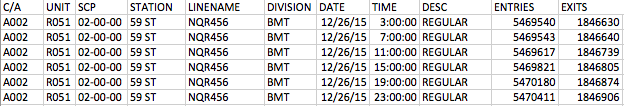

In [6]:
Image(filename='benson_data.png')

* C/A      = Control Area (A002)
* UNIT     = Remote Unit for a station (R051)
* SCP      = Subunit Channel Position represents an specific address for a device (02-00-00)
* STATION  = Represents the station name the device is located at
* LINENAME = Represents all train lines that can be boarded at this stationNormally lines are represented by one character.  LINENAME 456NQR repersents train server for 4, 5, 6, N, Q, and R trains.
* DIVISION = Represents the Line originally the station belonged to BMT, IRT, or IND   
* DATE     = Represents the date (MM-DD-YY)
* TIME     = Represents the time (hh:mm:ss) for a scheduled audit event
* DESC     = Represent the "REGULAR" scheduled audit event (Normally occurs every 4 hours)
 1. Audits may occur more that 4 hours due to planning, or troubleshooting activities. 
 2. Additionally, there may be a "RECOVR AUD" entry: This refers to a missed audit that was recovered. 
* ENTRIES  = The cumulative entry register value for a device
* EXITS    = The cumulative exit register value for a device

 ## Line Data Function <a name="Line Data Function"></a>

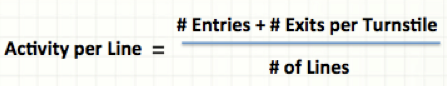

In [7]:
Image(filename='activityperline.png')

* The above equation represents part of the code in read_csv that's most important. It gives the activity for each line based on turnstileID (scp, unit, station), which is then added as part of the total for each line that it was in. 
* The script also fixes negative entries and exits issue by taking the absolute value for less than -15,000 and setting anything less to zero. It also creates consistent 4 hour intervals throughout day that wasn’t in data set

In [ ]:
def read_csv(filename):
    prevTurnstileID = ''
    old_row = ''
    lineData = {}
    ideal_time = (3, 7, 11, 15, 19, 23)
    with open(filename, 'rU') as f:
        reader = csv.reader(f)
        reader.next()
        for row in reader:
            unit = row[1]
            scp = row[2]
            station = row[3]
            lines = row[4]
            date = row[6]
            time = row[7]
            turnstileID = (scp, unit, station)
            date_time = datetime.strptime(date + " " + time, "%m/%d/%Y %H:%M:%S")
            entries = int(row[9])
            exits = int(row[10])
            '''
            We are testing to see if our current turnstile is the same as the previous turnstile.  If it is, we can deduct the current
            entries and exits from the previous ones to determine the total entries and exits for the difference in time.

            '''
            if turnstileID == prevTurnstileID:
                difEntries = entries - prevEntries
                difExits = exits - prevExits
                if difEntries < -15000:
                    print "DifEntries: %s" % difEntries
                    difEntries = 0
                elif difEntries < 0:
                    difEntries = abs(difEntries)
                if difExits < -15000:
                    print "DifExits: %s" % difExits
                    difExits = 0
                elif difExits < 0:
                    difExits = abs(difExits)
                numLines = len(lines)
                averAct = (difEntries + difExits)/numLines
                for line in lines:
                    if date_time.minute >= 30:
                        date_time += timedelta(hours = 1)
                        date_time = date_time.replace(minute=0, second=0)
                    elif date_time.minute < 30 and date_time.minute != 0:
                        date_time -= timedelta(hours = 1)
                        date_time = date_time.replace(minute=0, second=0)
                    if date_time.hour not in ideal_time:
                        #print('not in ideal_time zomg')
                        if date_time.hour < 3:
                            date_time = date_time.replace(hour=3)
                        else:
                            for val in ideal_time:
                                if abs(date_time.hour - val) <= 2:
                                    date_time = date_time.replace(hour=val)

                    if line in lineData:
                        if str(date_time) in lineData[line]:
                            lineData[line][str(date_time)] += averAct
                        else:
                            lineData[line][str(date_time)] = averAct
                    else:
                        lineData[line] = {str(date_time): averAct}
            prevTurnstileID = turnstileID
            prevEntries = entries
            prevExits = exits
            old_row = row
        return lineData

Below is waht lineData represents

In [3]:
lineData={'1': {'2016-01-11 07:00:00': 74, '2016-01-10 15:00:00': 320, '2016-01-11 11:00:00': 776, '2016-01-11 03:00:00': 23, '2016-01-10 19:00:00': 317, '2016-01-10 23:00:00': 139},
          'N': {'2016-01-09 07:00:00': 3, '2016-01-09 23:00:00': 51, '2016-01-09 15:00:00': 55, '2016-01-09 19:00:00': 75, '2016-01-09 11:00:00': 31, '2016-01-10 03:00:00': 17},
          'Q': {'2016-01-09 07:00:00': 3, '2016-01-09 23:00:00': 51, '2016-01-09 15:00:00': 55, '2016-01-09 19:00:00': 75, '2016-01-09 11:00:00': 31, '2016-01-10 03:00:00': 17},
          '3': {'2016-01-09 19:00:00': 597, '2016-01-09 23:00:00': 403, '2016-01-12 19:00:00': 691, '2016-01-09 07:00:00': 229, '2016-01-13 03:00:00': 75, '2016-01-09 15:00:00': 513, '2016-01-15 08:00:00': 189, '2016-01-14 08:00:00': 180, '2016-01-15 04:00:00': 25, '2016-01-14 04:00:00': 15, '2016-01-14 12:00:00': 390, '2016-01-15 00:00:00': 125, '2016-01-09 11:00:00': 427, '2016-01-12 23:00:00': 295, '2016-01-14 16:00:00': 312, '2016-01-14 20:00:00': 393, '2016-01-10 03:00:00': 226},
          'R': {'2016-01-09 07:00:00': 3, '2016-01-09 23:00:00': 51, '2016-01-09 15:00:00': 55, '2016-01-09 19:00:00': 75, '2016-01-09 11:00:00': 31, '2016-01-10 03:00:00': 17},
          '5': {'2016-01-11 12:00:00': 313, '2016-01-10 07:00:00': 46, '2016-01-09 07:00:00': 83, '2016-01-12 04:00:00': 9, '2016-01-09 23:00:00': 314, '2016-01-09 15:00:00': 494, '2016-01-11 08:00:00': 378, '2016-01-09 19:00:00': 487, '2016-01-11 20:00:00': 302, '2016-01-12 00:00:00': 74, '2016-01-12 12:00:00': 307, '2016-01-11 16:00:00': 309, '2016-01-09 11:00:00': 358, '2016-01-12 08:00:00': 447, '2016-01-10 03:00:00': 131},
          '4': {'2016-01-09 07:00:00': 3, '2016-01-09 23:00:00': 51, '2016-01-09 15:00:00': 55, '2016-01-09 19:00:00': 75, '2016-01-09 11:00:00': 31, '2016-01-10 03:00:00': 17},
          '7': {'2016-01-13 15:00:00': 490, '2016-01-12 19:00:00': 1048, '2016-01-13 03:00:00': 97, '2016-01-12 23:00:00': 490, '2016-01-13 07:00:00': 148, '2016-01-13 11:00:00': 794},
          '6': {'2016-01-09 07:00:00': 3, '2016-01-09 23:00:00': 51, '2016-01-09 15:00:00': 55, '2016-01-09 19:00:00': 75, '2016-01-09 11:00:00': 31, '2016-01-10 03:00:00': 17},
          '2': {'2016-01-09 19:00:00': 412, '2016-01-09 23:00:00': 263, '2016-01-09 07:00:00': 80, '2016-01-09 15:00:00': 439, '2016-01-10 07:00:00': 46, '2016-01-15 08:00:00': 189, '2016-01-14 08:00:00': 180, '2016-01-15 04:00:00': 25, '2016-01-14 04:00:00': 15, '2016-01-14 12:00:00': 390, '2016-01-15 00:00:00': 125, '2016-01-09 11:00:00': 327, '2016-01-14 16:00:00': 312, '2016-01-14 20:00:00': 393, '2016-01-10 03:00:00': 114}}

 ## Plotting Line Activity <a name="Plotting Line Activity"></a>

LineColors and lineStyles below are created for plotting

In [4]:
lineColors={"A":"#2850ad","C":"#2850ad","E":"#2850ad",
            "B":"#ff6319","D":"#ff6319","F":"#ff6319","M":"#ff6319",
            "G":"#6cbe45",
            "L":"#a7a9ac",
            "J":"#996633","Z":"#996633",
            "N":"#fccc0a","Q":"#fccc0a","R":"#fccc0a",
            "1":"#ee352e","2":"#ee352e","3":"#ee352e",
            "4":"#00933c","5":"#00933c","6":"#00933c",
            "7":"#b933ad",
            "S":"#808183"}

In [5]:
lineStyles={"A":"-","C":":","E":"-.",
            "B":"-","D":":","F":"-.","M":"--",
            "G":"-",
            "L":"-",
            "J":"-","Z":":",
            "N":"-","Q":":","R":"-.",
            "1":"-","2":":","3":"-.",
            "4":"-","5":":","6":"-.",
            "7":"-",
            "S":"-"}

AddLine function below adds information from lineData for plotting

In [ ]:
plotList=[]
import time
def addLine(thisLine):
    lineTimeData={}
    for eachTime in lineData[thisLine]:
        tempTime = datetime.strptime(eachTime, "%Y-%m-%d %H:%M:%S")
        lineTimeData[tempTime] = lineData[thisLine][eachTime]
    timeList = lineTimeData.keys()
    timeList.sort()
    activityList=[]
    for eachTime in timeList:
        activityList.append(lineTimeData[eachTime])
    labelName = 'Line ' + thisLine
    line1_patch = mpatches.Patch(color=lineColors[thisLine], label=labelName)
    # plt.legend(handles=[line1_patch])
    plt.plot(timeList, activityList, linewidth=2,color=lineColors[thisLine],label=labelName,linestyle=lineStyles[thisLine])
    thisPlot, = plt.plot(timeList, activityList, linewidth=2,color=lineColors[thisLine],label=labelName,linestyle=lineStyles[thisLine])
    plotList.append(thisPlot)

Below is the main program - all that is needed at the end to run and plot

Now doing Line: 1
LineEpochData:
{1452466800: 320, 1452538800: 776, 1452524400: 74, 1452481200: 317, 1452495600: 139, 1452510000: 23}
Now doing Line: Q
LineEpochData:
{1452409200: 51, 1452366000: 31, 1452380400: 55, 1452394800: 75, 1452351600: 3, 1452423600: 17}
Now doing Line: 3
LineEpochData:
{1452772800: 15, 1452873600: 189, 1452801600: 390, 1452351600: 229, 1452366000: 427, 1452380400: 513, 1452394800: 597, 1452654000: 691, 1452409200: 403, 1452423600: 226, 1452668400: 295, 1452787200: 180, 1452682800: 75, 1452859200: 25, 1452816000: 312, 1452830400: 393, 1452844800: 125}
Now doing Line: R
LineEpochData:
{1452409200: 51, 1452366000: 31, 1452380400: 55, 1452394800: 75, 1452351600: 3, 1452423600: 17}
Now doing Line: 5
LineEpochData:
{1452528000: 378, 1452380400: 494, 1452351600: 83, 1452366000: 358, 1452394800: 487, 1452438000: 46, 1452409200: 314, 1452423600: 131, 1452542400: 313, 1452556800: 309, 1452628800: 307, 1452571200: 302, 1452585600: 74, 1452600000: 9, 1452614400: 447}
Now 

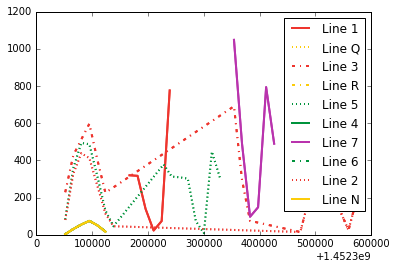

In [7]:
filename = './turnstile_160109.csv'
lineData = read_csv(filename)

for eachLine in lineData:
    addLine(eachLine)

plt.legend(handles=plotList,bbox_to_anchor=(1,1),bbox_transform=plt.gcf().transFigure)
plt.grid()
plt.suptitle('Total Activity Per NYC Metro Line', fontsize=28)
plt.xlabel('Time (Days)',fontsize='18')
plt.ylabel('Activity (Entries + Exits)',fontsize='18')
plt.axis('tight')
plt.show()

Below is a blown up image of the activity line plot:

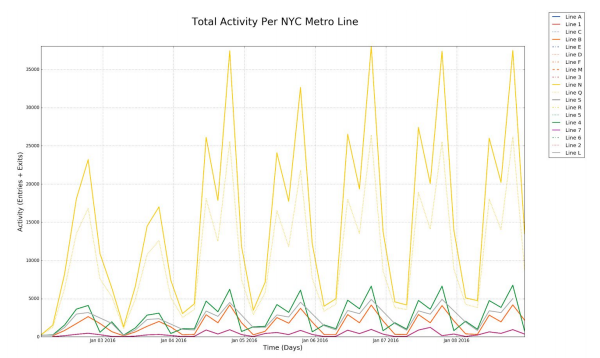

In [9]:
Image(filename='activitylineplot.png')

* Y Axis: 0 to 35,000 Activities
* X Axis: First Week of January
* Legend: All the lines and their corresponding colors

 ## Conclusion <a name="Conclusion"></a>

* This analysis shows the most influential subway line to strike would be NYC’s “N” line, which runs from Queens to Manhattan midtown, then to Times Square (34th Street), down to Union Square (14th Street), then finally to Brooklyn.
* Further improvements could include better estimations of Activity Per Line, inclusion of dependencies between lines, and analysis of longer time periods. 